## Importing Packages

In [103]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install streamlit

  Using cached streamlit-1.27.2-py2.py3-none-any.whl.metadata (8.1 kB)
  Using cached altair-5.1.2-py3-none-any.whl.metadata (8.6 kB)
  Using cached blinker-1.6.3-py3-none-any.whl.metadata (1.9 kB)
  Using cached importlib_metadata-6.8.0-py3-none-any.whl.metadata (5.1 kB)
  Using cached pyarrow-13.0.0-cp311-cp311-win_amd64.whl.metadata (3.1 kB)
  Using cached rich-13.6.0-py3-none-any.whl.metadata (18 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl (16 kB)
  Using cached tzlocal-5.1-py3-none-any.whl.metadata (16 kB)
  Using cached validators-0.22.0-py3-none-any.whl.metadata (4.7 kB)
  Using cached GitPython-3.1.40-py3-none-any.whl.metadata (12 kB)
  Using cached pydeck-0.8.1b0-py2.py3-none-any.whl (4.8 MB)
  Using cached watchdog-3.0.0-py3-none-win_amd64.whl (82 kB)
  Using cached toolz-0.12.0-py3-none-any.whl (55 kB)
  Using cached gitdb-4.0.11-py3-none-any.whl.metadata (1.2 kB)
  Using cached zipp-3.17.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached markdown_it_py-3.0.0-py3-no

In [104]:
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [105]:
%pip install torch

Note: you may need to restart the kernel to use updated packages.


In [259]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product
from datetime import timedelta
import pickle

In [246]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Loading Dataset

In [247]:
df = pd.read_csv('final_merged_copper_dataset_new.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df["Date"] = pd.to_datetime(df["Date"])
df

,Date,Price,Open,High,Low,Vol.,Change %,Month,Year,Real_GDP,CPI,inflation_rate,PALLFNFINDEXM
0,2023-10-05,3.5520,3.5830,3.6030,3.5490,58.69,1.03,10.0,2023.0,19374.000,NaN,6.600000,NaN
1,2023-10-04,3.5890,3.6185,3.6220,3.5490,76.86,0.88,10.0,2023.0,19374.000,NaN,6.600000,NaN
2,2023-10-03,3.6210,3.6480,3.6480,3.5815,69.45,0.56,10.0,2023.0,19374.000,NaN,6.600000,NaN
3,2023-10-02,3.6415,3.7540,3.7615,3.6275,74.92,2.57,10.0,2023.0,19374.000,NaN,6.600000,NaN
4,2023-09-29,3.7375,3.7125,3.7860,3.7115,82.33,0.80,9.0,2023.0,19374.000,NaN,6.600000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2702,2013-01-07,3.6780,3.7035,3.7135,3.6525,39.01,0.03,1.0,2013.0,17812.167,232.166,1.464833,232.166
2703,2013-01-06,3.6790,3.6840,3.6900,3.6710,0.29,0.39,1.0,2013.0,17812.167,232.166,1.464833,232.166
2704,2013-01-04,3.6935,3.6935,3.7070,3.6710,45.82,0.63,1.0,2013.0,17812.167,232.166,1.464833,232.166
2705,2013-01-03,3.7170,3.7315,3.7590,3.6900,44.09,0.51,1.0,2013.0,17812.167,232.166,1.464833,232.166


In [255]:
last_date = df['Date'].max().date()
last_date

datetime.date(2023, 10, 5)

In [174]:
df.isnull().sum()

Date               0
Price              0
Open               0
High               0
Low                0
Vol.               0
Change %           0
Month              0
Year               0
Real_GDP           0
CPI               24
inflation_rate     0
PALLFNFINDEXM     24
dtype: int64

In [175]:
# Set a constant value for missing 'CPI' in the year 2023
constant_value_CPI_2023 = 307.0
# Fill the missing 'CPI' values with the constant value for 2023
df['CPI'] = df['CPI'].fillna(
    df['Year'].apply(lambda x: constant_value_CPI_2023 if x == 2023 else np.nan))

# Set a constant value for missing 'PALLFNFINDEXM' in the year 2023
constant_value_PALLFNFINDEXM_2023 = 161.45
# Fill the missing 'PALLFNFINDEXM' values with the constant value for 2023
df['PALLFNFINDEXM'] = df['PALLFNFINDEXM'].fillna(
    df['Year'].apply(lambda x: constant_value_PALLFNFINDEXM_2023 if x == 2023 else np.nan))

df.isnull().sum()

Date              0
Price             0
Open              0
High              0
Low               0
Vol.              0
Change %          0
Month             0
Year              0
Real_GDP          0
CPI               0
inflation_rate    0
PALLFNFINDEXM     0
dtype: int64

In [176]:
df = df.drop(['Month','Year', 'Open', 'High', 'Low', 'Vol.', 'Change %'], axis=1)
df

,Date,Price,Real_GDP,CPI,inflation_rate,PALLFNFINDEXM
0,2023-10-05,3.5520,19374.000,307.000,6.600000,161.450
1,2023-10-04,3.5890,19374.000,307.000,6.600000,161.450
2,2023-10-03,3.6210,19374.000,307.000,6.600000,161.450
3,2023-10-02,3.6415,19374.000,307.000,6.600000,161.450
4,2023-09-29,3.7375,19374.000,307.000,6.600000,161.450
...,...,...,...,...,...,...
2702,2013-01-07,3.6780,17812.167,232.166,1.464833,232.166
2703,2013-01-06,3.6790,17812.167,232.166,1.464833,232.166
2704,2013-01-04,3.6935,17812.167,232.166,1.464833,232.166
2705,2013-01-03,3.7170,17812.167,232.166,1.464833,232.166


In [177]:
df = df.iloc[::-1]

df.reset_index(drop=True, inplace=True)
df

,Date,Price,Real_GDP,CPI,inflation_rate,PALLFNFINDEXM
0,2013-01-02,3.7360,17812.167,232.166,1.464833,232.166
1,2013-01-03,3.7170,17812.167,232.166,1.464833,232.166
2,2013-01-04,3.6935,17812.167,232.166,1.464833,232.166
3,2013-01-06,3.6790,17812.167,232.166,1.464833,232.166
4,2013-01-07,3.6780,17812.167,232.166,1.464833,232.166
...,...,...,...,...,...,...
2702,2023-09-29,3.7375,19374.000,307.000,6.600000,161.450
2703,2023-10-02,3.6415,19374.000,307.000,6.600000,161.450
2704,2023-10-03,3.6210,19374.000,307.000,6.600000,161.450
2705,2023-10-04,3.5890,19374.000,307.000,6.600000,161.450


In [178]:
LOOKBACK = 7
data = pd.DataFrame({'Date': df["Date"].copy(),
                     'Price': df["Price"].copy()})
# Select the "Date" column and store it in the variable 'train_dates'.
dates = data["Date"]

# Exclude the first 'LOOKBACK' dates from 'train_dates' to create a time window.
dates = dates[LOOKBACK:]
data.dtypes

Date     datetime64[ns]
Price           float64
dtype: object

In [179]:
dates.reset_index(drop=True, inplace=True)

In [180]:
dates

0      2013-01-10
1      2013-01-11
2      2013-01-13
3      2013-01-14
4      2013-01-15
          ...    
2695   2023-09-29
2696   2023-10-02
2697   2023-10-03
2698   2023-10-04
2699   2023-10-05
Name: Date, Length: 2700, dtype: datetime64[ns]

In [181]:
from copy import deepcopy as dc


def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    #df.set_index('Date', inplace=True)

    for i in range(1, n_steps + 1):
        df[f'Price(t-{i})'] = df['Price'].shift(i)

    df.dropna(inplace=True)

    return df


shifted_df = prepare_dataframe_for_lstm(data, LOOKBACK)
df = df.drop(df.index[-7:])
df

,Date,Price,Real_GDP,CPI,inflation_rate,PALLFNFINDEXM
0,2013-01-02,3.7360,17812.167,232.166,1.464833,232.166
1,2013-01-03,3.7170,17812.167,232.166,1.464833,232.166
2,2013-01-04,3.6935,17812.167,232.166,1.464833,232.166
3,2013-01-06,3.6790,17812.167,232.166,1.464833,232.166
4,2013-01-07,3.6780,17812.167,232.166,1.464833,232.166
...,...,...,...,...,...,...
2695,2023-09-20,3.7760,19374.000,307.000,6.600000,161.450
2696,2023-09-21,3.6960,19374.000,307.000,6.600000,161.450
2697,2023-09-22,3.6960,19374.000,307.000,6.600000,161.450
2698,2023-09-25,3.6700,19374.000,307.000,6.600000,161.450


In [182]:
df = df.drop(['Date','Price'], axis=1)
df

,Real_GDP,CPI,inflation_rate,PALLFNFINDEXM
0,17812.167,232.166,1.464833,232.166
1,17812.167,232.166,1.464833,232.166
2,17812.167,232.166,1.464833,232.166
3,17812.167,232.166,1.464833,232.166
4,17812.167,232.166,1.464833,232.166
...,...,...,...,...
2695,19374.000,307.000,6.600000,161.450
2696,19374.000,307.000,6.600000,161.450
2697,19374.000,307.000,6.600000,161.450
2698,19374.000,307.000,6.600000,161.450


In [183]:
GDP_before_scaling_as_np = df["Real_GDP"].to_numpy()
CPI_before_scaling_as_np = df["CPI"].to_numpy()
inflation_rate_before_scaling_as_np = df["inflation_rate"].to_numpy()
PALLFNFINDEXM_before_scaling_as_np = df["PALLFNFINDEXM"].to_numpy()

In [184]:
GDP_scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_GDP = GDP_scaler.fit_transform(GDP_before_scaling_as_np.reshape(-1, 1))

In [185]:
scaled_GDP

array([[-1.        ],
       [-1.        ],
       [-1.        ],
       ...,
       [-0.22100567],
       [-0.22100567],
       [-0.22100567]])

In [186]:
CPI_scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_CPI = CPI_scaler.fit_transform(CPI_before_scaling_as_np.reshape(-1, 1))

In [187]:
scaled_CPI

array([[-1.        ],
       [-1.        ],
       [-1.        ],
       ...,
       [ 0.99930537],
       [ 0.99930537],
       [ 0.99930537]])

In [188]:
IR_scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_IR = IR_scaler.fit_transform(inflation_rate_before_scaling_as_np.reshape(-1, 1))

In [189]:
scaled_IR

array([[-0.6585043 ],
       [-0.6585043 ],
       [-0.6585043 ],
       ...,
       [ 0.64414787],
       [ 0.64414787],
       [ 0.64414787]])

In [190]:
PALLFNFINDEXM_scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_PALLFNFINDEXM = PALLFNFINDEXM_scaler.fit_transform(PALLFNFINDEXM_before_scaling_as_np.reshape(-1, 1))

In [191]:
scaled_PALLFNFINDEXM

array([[-0.02846623],
       [-0.02846623],
       [-0.02846623],
       ...,
       [-1.        ],
       [-1.        ],
       [-1.        ]])

In [192]:
flipped_df = shifted_df[shifted_df.columns[::-1]]
flipped_df = flipped_df.drop(['Date'], axis=1)


In [193]:
flipped_df.reset_index(drop=True, inplace=True)

In [194]:
new_df = pd.concat([df, flipped_df], axis=1)

In [195]:
new_df

,Real_GDP,CPI,inflation_rate,PALLFNFINDEXM,Price(t-7),Price(t-6),Price(t-5),Price(t-4),Price(t-3),Price(t-2),Price(t-1),Price
0,17812.167,232.166,1.464833,232.166,3.7360,3.7170,3.6935,3.6790,3.6780,3.6720,3.6705,3.7090
1,17812.167,232.166,1.464833,232.166,3.7170,3.6935,3.6790,3.6780,3.6720,3.6705,3.7090,3.6540
2,17812.167,232.166,1.464833,232.166,3.6935,3.6790,3.6780,3.6720,3.6705,3.7090,3.6540,3.6390
3,17812.167,232.166,1.464833,232.166,3.6790,3.6780,3.6720,3.6705,3.7090,3.6540,3.6390,3.6340
4,17812.167,232.166,1.464833,232.166,3.6780,3.6720,3.6705,3.7090,3.6540,3.6390,3.6340,3.6375
...,...,...,...,...,...,...,...,...,...,...,...,...
2695,19374.000,307.000,6.600000,161.450,3.7760,3.6960,3.6960,3.6700,3.6490,3.6365,3.7080,3.7375
2696,19374.000,307.000,6.600000,161.450,3.6960,3.6960,3.6700,3.6490,3.6365,3.7080,3.7375,3.6415
2697,19374.000,307.000,6.600000,161.450,3.6960,3.6700,3.6490,3.6365,3.7080,3.7375,3.6415,3.6210
2698,19374.000,307.000,6.600000,161.450,3.6700,3.6490,3.6365,3.7080,3.7375,3.6415,3.6210,3.5890


In [196]:
flipped_df

,Price(t-7),Price(t-6),Price(t-5),Price(t-4),Price(t-3),Price(t-2),Price(t-1),Price
0,3.7360,3.7170,3.6935,3.6790,3.6780,3.6720,3.6705,3.7090
1,3.7170,3.6935,3.6790,3.6780,3.6720,3.6705,3.7090,3.6540
2,3.6935,3.6790,3.6780,3.6720,3.6705,3.7090,3.6540,3.6390
3,3.6790,3.6780,3.6720,3.6705,3.7090,3.6540,3.6390,3.6340
4,3.6780,3.6720,3.6705,3.7090,3.6540,3.6390,3.6340,3.6375
...,...,...,...,...,...,...,...,...
2695,3.7760,3.6960,3.6960,3.6700,3.6490,3.6365,3.7080,3.7375
2696,3.6960,3.6960,3.6700,3.6490,3.6365,3.7080,3.7375,3.6415
2697,3.6960,3.6700,3.6490,3.6365,3.7080,3.7375,3.6415,3.6210
2698,3.6700,3.6490,3.6365,3.7080,3.7375,3.6415,3.6210,3.5890


In [197]:
flipped_df_before_scaling_as_np = flipped_df.to_numpy()
flipped_df_before_scaling_as_np

array([[3.736 , 3.717 , 3.6935, ..., 3.672 , 3.6705, 3.709 ],
       [3.717 , 3.6935, 3.679 , ..., 3.6705, 3.709 , 3.654 ],
       [3.6935, 3.679 , 3.678 , ..., 3.709 , 3.654 , 3.639 ],
       ...,
       [3.696 , 3.67  , 3.649 , ..., 3.7375, 3.6415, 3.621 ],
       [3.67  , 3.649 , 3.6365, ..., 3.6415, 3.621 , 3.589 ],
       [3.649 , 3.6365, 3.708 , ..., 3.621 , 3.589 , 3.552 ]])

In [198]:
price_scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_prices = price_scaler.fit_transform(flipped_df_before_scaling_as_np)

In [199]:
scaled_prices

array([[0.19739479, 0.18470274, 0.16900468, ..., 0.15464262, 0.15364061,
        0.17935872],
       [0.18470274, 0.16900468, 0.15931864, ..., 0.15364061, 0.17935872,
        0.14261857],
       [0.16900468, 0.15931864, 0.15865063, ..., 0.17935872, 0.14261857,
        0.13259853],
       ...,
       [0.17067468, 0.15330661, 0.13927856, ..., 0.19839679, 0.13426854,
        0.12057448],
       [0.15330661, 0.13927856, 0.13092852, ..., 0.13426854, 0.12057448,
        0.0991984 ],
       [0.13927856, 0.13092852, 0.17869071, ..., 0.12057448, 0.0991984 ,
        0.0744823 ]])

In [200]:
result = np.concatenate((scaled_GDP, scaled_CPI, scaled_IR, scaled_PALLFNFINDEXM, scaled_prices), axis=1)
result

array([[-1.        , -1.        , -0.6585043 , ...,  0.15464262,
         0.15364061,  0.17935872],
       [-1.        , -1.        , -0.6585043 , ...,  0.15364061,
         0.17935872,  0.14261857],
       [-1.        , -1.        , -0.6585043 , ...,  0.17935872,
         0.14261857,  0.13259853],
       ...,
       [-0.22100567,  0.99930537,  0.64414787, ...,  0.19839679,
         0.13426854,  0.12057448],
       [-0.22100567,  0.99930537,  0.64414787, ...,  0.13426854,
         0.12057448,  0.0991984 ],
       [-0.22100567,  0.99930537,  0.64414787, ...,  0.12057448,
         0.0991984 ,  0.0744823 ]])

In [201]:
X = result[:, 0:11]
y = result[:, 11]
X = X.astype(np.float32)
y = y.astype(np.float32)
X.dtype

dtype('float32')

In [202]:
X

array([[-1.        , -1.        , -0.6585043 , ...,  0.15865064,
         0.15464261,  0.15364061],
       [-1.        , -1.        , -0.6585043 , ...,  0.15464261,
         0.15364061,  0.17935872],
       [-1.        , -1.        , -0.6585043 , ...,  0.15364061,
         0.17935872,  0.14261857],
       ...,
       [-0.22100566,  0.99930537,  0.6441479 , ...,  0.17869072,
         0.19839679,  0.13426854],
       [-0.22100566,  0.99930537,  0.6441479 , ...,  0.19839679,
         0.13426854,  0.12057448],
       [-0.22100566,  0.99930537,  0.6441479 , ...,  0.13426854,
         0.12057448,  0.09919839]], dtype=float32)

In [218]:
split_index = int(len(X) * 0.80)
split_date = dates[split_index]

X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]
train_dates = dates[:split_index]
test_dates = dates[split_index:]
test_dates

2160   2021-08-03
2161   2021-08-04
2162   2021-08-05
2163   2021-08-06
2164   2021-08-09
          ...    
2695   2023-09-29
2696   2023-10-02
2697   2023-10-03
2698   2023-10-04
2699   2023-10-05
Name: Date, Length: 540, dtype: datetime64[ns]

In [205]:
X_train

array([[-1.        , -1.        , -0.6585043 , ...,  0.15865064,
         0.15464261,  0.15364061],
       [-1.        , -1.        , -0.6585043 , ...,  0.15464261,
         0.15364061,  0.17935872],
       [-1.        , -1.        , -0.6585043 , ...,  0.15364061,
         0.17935872,  0.14261857],
       ...,
       [ 0.79333746,  0.09102324,  0.16162644, ...,  0.76452905,
         0.737475  ,  0.6957248 ],
       [ 0.79333746,  0.09102324,  0.16162644, ...,  0.737475  ,
         0.6957248 ,  0.71275884],
       [ 0.79333746,  0.09102324,  0.16162644, ...,  0.6957248 ,
         0.71275884,  0.68470275]], dtype=float32)

In [140]:
X_train.shape

(2160, 11)

In [219]:
X = X.reshape((-1, LOOKBACK+4, 1))
X_test = X_test.reshape((-1, LOOKBACK+4, 1))

y = y.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

In [220]:
X = torch.tensor(X).float()
y = torch.tensor(y).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

#X_test.dtype

C:\Users\George Welson\AppData\Local\Temp\ipykernel_17860\1450774100.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X).float()
C:\Users\George Welson\AppData\Local\Temp\ipykernel_17860\1450774100.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).float()
C:\Users\George Welson\AppData\Local\Temp\ipykernel_17860\1450774100.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test).float()
C:\Users\George Welson\AppData\Local\Temp\ipykernel_17860\1450774100.py:4: UserWarning:

In [221]:
X_test.shape

torch.Size([540, 11, 1])

In [222]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X, y)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [223]:
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [224]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([8, 11, 1]) torch.Size([8, 1])


In [225]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [229]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.5f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [230]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.5f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [231]:
learning_rate = 0.001
num_epochs = 30
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#Adam does the gradient descent

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.00089
Batch 200, Loss: 0.00093
Batch 300, Loss: 0.00086

Val Loss: 0.00189
***************************************************

Epoch: 2
Batch 100, Loss: 0.00091
Batch 200, Loss: 0.00094
Batch 300, Loss: 0.00089

Val Loss: 0.00204
***************************************************

Epoch: 3
Batch 100, Loss: 0.00089
Batch 200, Loss: 0.00088
Batch 300, Loss: 0.00091

Val Loss: 0.00184
***************************************************

Epoch: 4
Batch 100, Loss: 0.00079
Batch 200, Loss: 0.00102
Batch 300, Loss: 0.00089

Val Loss: 0.00182
***************************************************

Epoch: 5
Batch 100, Loss: 0.00088
Batch 200, Loss: 0.00095
Batch 300, Loss: 0.00090

Val Loss: 0.00182
***************************************************

Epoch: 6
Batch 100, Loss: 0.00095
Batch 200, Loss: 0.00085
Batch 300, Loss: 0.00086

Val Loss: 0.00189
***************************************************

Epoch: 7
Batch 100, Loss: 0.00097
Batch 200, Loss: 0.00091
Batch

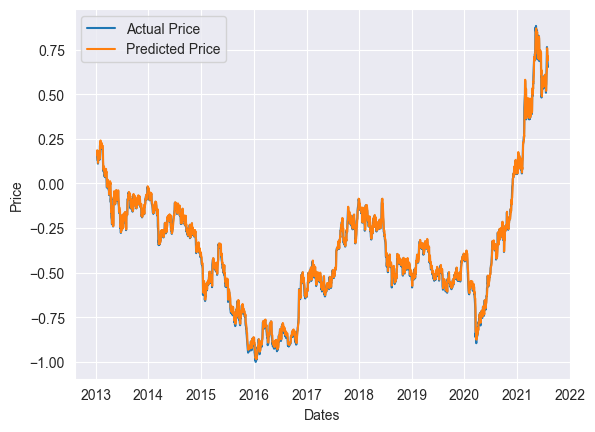

In [232]:
with torch.no_grad():
    predicted = model(X_train[:].to(device)).to('cpu').numpy()

plt.plot(train_dates, y_train, label='Actual Price')
plt.plot(train_dates, predicted, label='Predicted Price')

plt.xlabel('Dates')
plt.ylabel('Price')
plt.legend()
plt.show()


In [233]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], LOOKBACK+1))
dummies[:, 0] = train_predictions
dummies = price_scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([3.67905765, 3.71923309, 3.66033046, ..., 4.49182251, 4.51004664,
       4.4743445 ])

In [234]:
dummies = np.zeros((X_train.shape[0], LOOKBACK+1))
dummies[:, 0] = y_train.flatten()
dummies = price_scaler.inverse_transform(dummies)
new_y_train = dc(dummies[:, 0])
new_y_train

array([3.70900001, 3.65399999, 3.63900001, ..., 4.50749998, 4.46550002,
       4.41800004])

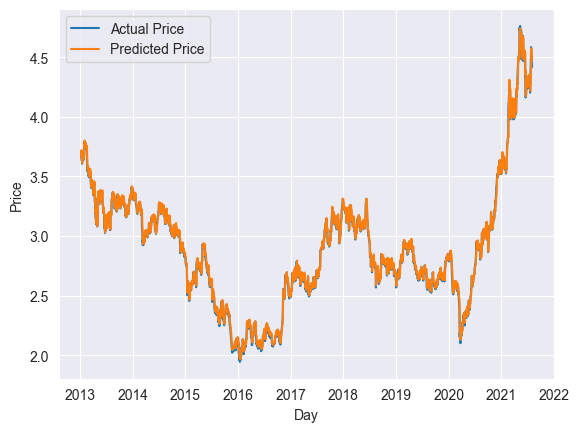

In [235]:
plt.plot(train_dates,new_y_train,  label='Actual Price')
plt.plot(train_dates,train_predictions, label='Predicted Price')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()

In [236]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], LOOKBACK+1))
dummies[:, 0] = test_predictions
dummies = price_scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([4.42797512, 4.38606698, 4.33354185, 4.3437077 , 4.35010063,
       4.29578638, 4.35403443, 4.37120344, 4.36148873, 4.39106786,
       4.33397576, 4.2153638 , 4.12861391, 4.05283101, 4.13891062,
       4.23510749, 4.27336727, 4.28250307, 4.26492316, 4.33261209,
       4.38086605, 4.3811953 , 4.28879598, 4.30899973, 4.34184792,
       4.29372316, 4.24528128, 4.29430787, 4.45153484, 4.38155079,
       4.33072625, 4.40910854, 4.29715559, 4.25567324, 4.12706736,
       4.1376653 , 4.2637557 , 4.24692076, 4.29491417, 4.30373643,
       4.26211462, 4.2119949 , 4.10186215, 4.1995589 , 4.25304886,
       4.20722994, 4.16010373, 4.25408855, 4.28911729, 4.37447651,
       4.339691  , 4.51029889, 4.62192135, 4.70946532, 4.71379797,
       4.6952254 , 4.7183188 , 4.57270756, 4.50454501, 4.52783017,
       4.49345199, 4.4022162 , 4.43234793, 4.37225785, 4.38707776,
       4.36336752, 4.32144242, 4.31993687, 4.34591172, 4.40235817,
       4.38455804, 4.33565557, 4.4037793 , 4.45351061, 4.41269

In [237]:
dummies = np.zeros((X_test.shape[0], LOOKBACK+1))
dummies[:, 0] = y_test.flatten()
dummies = price_scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test
squared_differences = (new_y_test - test_predictions)**2

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(np.mean(squared_differences))
#rmse
absolute_differences = np.abs(new_y_test - test_predictions)

# Calculate the Mean Absolute Error (MAE)
mae = np.mean(absolute_differences)
rmse

0.06394427876809756

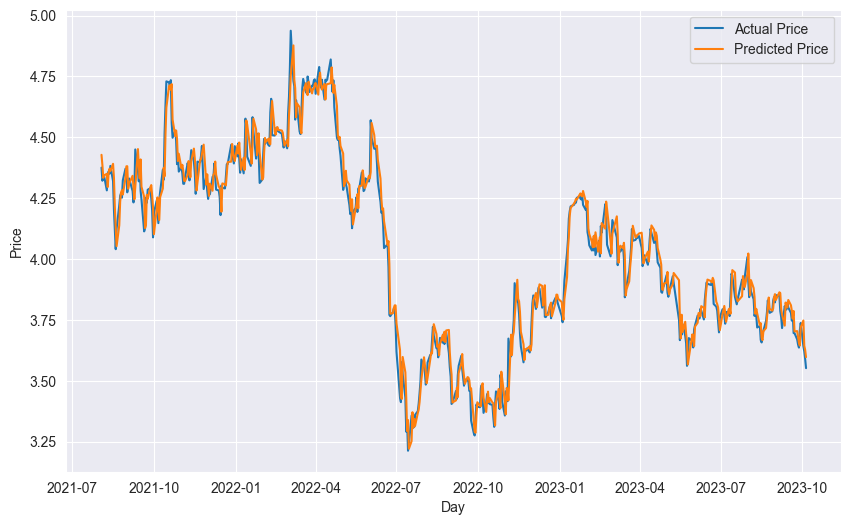

In [238]:
plt.figure(figsize=(10,6))
plt.plot(test_dates, new_y_test, label='Actual Price')
plt.plot(test_dates,test_predictions, label='Predicted Price')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()

In [239]:
test_dates

2160   2021-08-03
2161   2021-08-04
2162   2021-08-05
2163   2021-08-06
2164   2021-08-09
          ...    
2695   2023-09-29
2696   2023-10-02
2697   2023-10-03
2698   2023-10-04
2699   2023-10-05
Name: Date, Length: 540, dtype: datetime64[ns]

In [240]:
"""# Instantiate your model
model = LSTM(1, 4, 1)

# Save the model to a .pkl (pickle) file
model_file_path = 'LSTM.pkl'
with open(model_file_path, 'wb') as file:
    pickle.dump(model, file)"""

"# Instantiate your model\nmodel = LSTM(1, 4, 1)\n\n# Save the model to a .pkl (pickle) file\nmodel_file_path = 'LSTM.pkl'\nwith open(model_file_path, 'wb') as file:\n    pickle.dump(model, file)"

In [241]:
torch.save(model, 'model.pt')

In [242]:
m1 = torch.load('model.pt')

In [243]:
m1

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [244]:
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [263]:
start_date = last_date+timedelta(days=1)
end_date = "2024-01-25"
forecast_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Create a DataFrame with the date column
forecast_set = pd.DataFrame({'Date': forecast_dates})
forecast_set['Date'] = pd.to_datetime(forecast_set['Date'])
forecast_set

,Date
0,2023-10-06
1,2023-10-07
2,2023-10-08
3,2023-10-09
4,2023-10-10
...,...
107,2024-01-21
108,2024-01-22
109,2024-01-23
110,2024-01-24


In [260]:
last_date+timedelta(days=1)

datetime.date(2023, 10, 6)